关于子网掩码的借位, 子网的划分, 可以查查VLSM (variable-length subnet mask)

传统的子网划分, 比如网络地址为10.10.20.0, 借3位, 则可以分`2^3 = 8`个子网, 然后每个子网有`2^5 - 2 = 30`个host, 这样理论上可以有30*8 = 240个host, 可是考虑下, 一个公司的每个部门都一定需要30个host吗? 一个公司有8个部门需要8个子网, 然后开发部分需要60台电脑, 其他七个部门每个部门只需要3台电脑 可是为了满足最大host的那个子网要求, 我们必须为ip地址的host部分留6位数(可以容纳64个host), 但这样我们只能借两位来划分网络, 也就是只能划分4个网络, 这可怎么办? 明明一共也就60+21=81台电脑, 却没办法组, 这就是传统子网掩码的造成的网络地址的浪费, 只有开发部分需要60个host机位, 其他并不都需要60个机位呀, 这也就是VLSM被设计出来的原因

---

### 子网数和主机数怎么求？

subnet个数就是IP个数，通用的办法看subnets, 把非255的数字转成二进制，数一下有几个0，然后就做为2的指数，这就是IP数。

e.g., subnet mask `255.255.255.240`, `240`->`1111 0000`, 4个0，2^4=16，所以有16个IP, 主机数就是14个。

### 主机数为什么要减去2?

主机数减去2是因为要除去子网网络地址（主机号全0）和子网广播地址（主机号全1），每个子网的这两个地址都是保留不能分配给主机，所以要减去2。

至于子网个数减去2是因为很早以前的网络设备跟相关协议是不支持子网号全0跟全1。但是这都是很久以前的老书上这样的算法，现在一般都是不用减去2的，网络设备跟相关协议能都区分全0跟全1子网号了。

### Subnet vs Broadcast Domain

A **subnet** is short for sub network and is defined as a small network that sits within a larger network. The smallest subnet is called a **broadcast domain** and contains no more subdivisions the subnet. Its primary purpose is to route communication between devices on a data network through a device's MAC addresses.

**Broadcast** domain usually refers to the “layer 2” (e.g. Ethernet) segment, on which all nodes can broadcast to each other.

**Subnetwork** usually refers to the logical division of “layer 3” (e.g. IP) network that is a sub-segment of a larger network.


### 如何根据拓扑图确认子网数

- 1 router is 1 subnet, and 1 subnet equals to 1 brocast domain
- A router with 2 port will have 2 IP addresses
- 相连的的路由器(如果有switch看成线)算一个子网

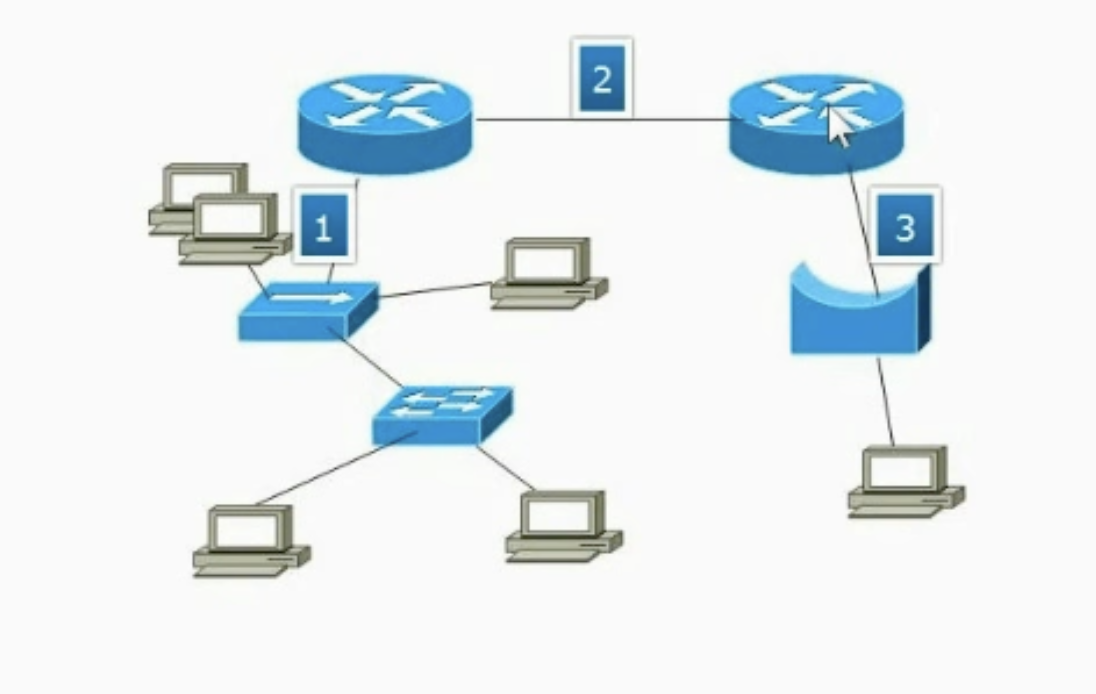

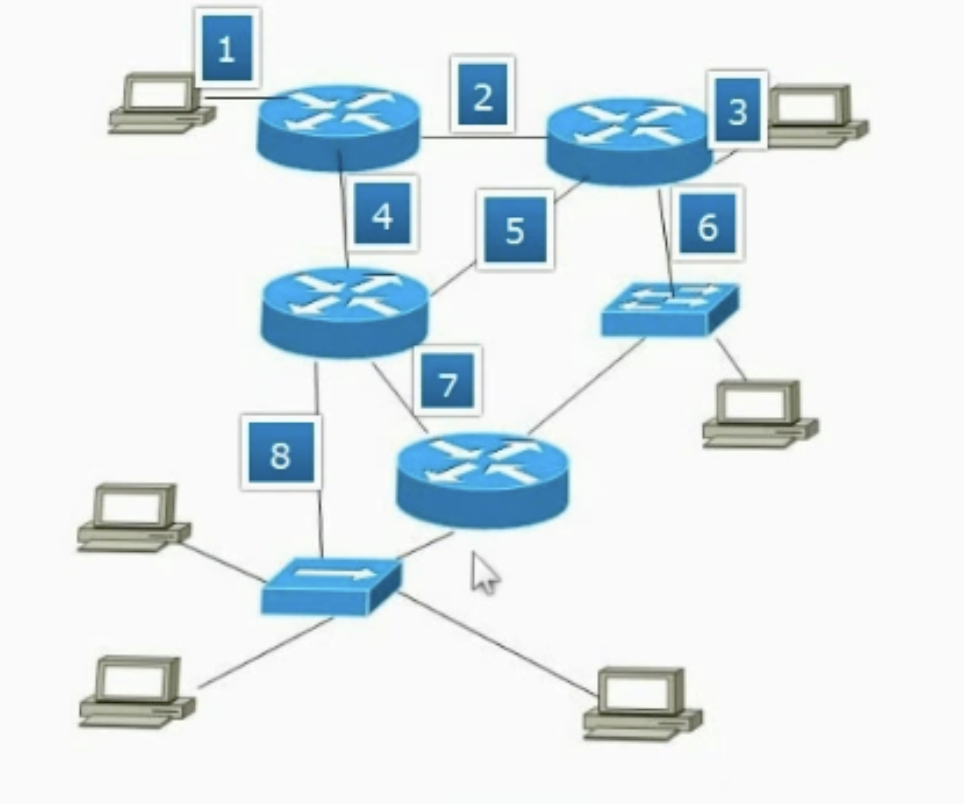

----
现有一个公开ip, 地址为192.168.100.0, 然后有五个子网, 然后为不同子网分配网络号, 

思路: 五个子网, 即需要五个网段, 怎么实现? 自定义子网掩码, ip地址最后8位为0, 因为只有五个子网, 所以用这8位的前三位编码网段即可(3位可编码8个网段). 所以子网掩码为 `192.168.100.1110 0000` 注意这么写是不对的, 我只是为了容易表达, 前三个是十进制, 最后一部分是二进制. 用这个子网掩码便可以分辨一个ip地址的网络部分和host部分. 看下图, 如何为每个网段分配ip, 可以看出, 广播ip(host部分都是1)和网段ip(host部分都是0)


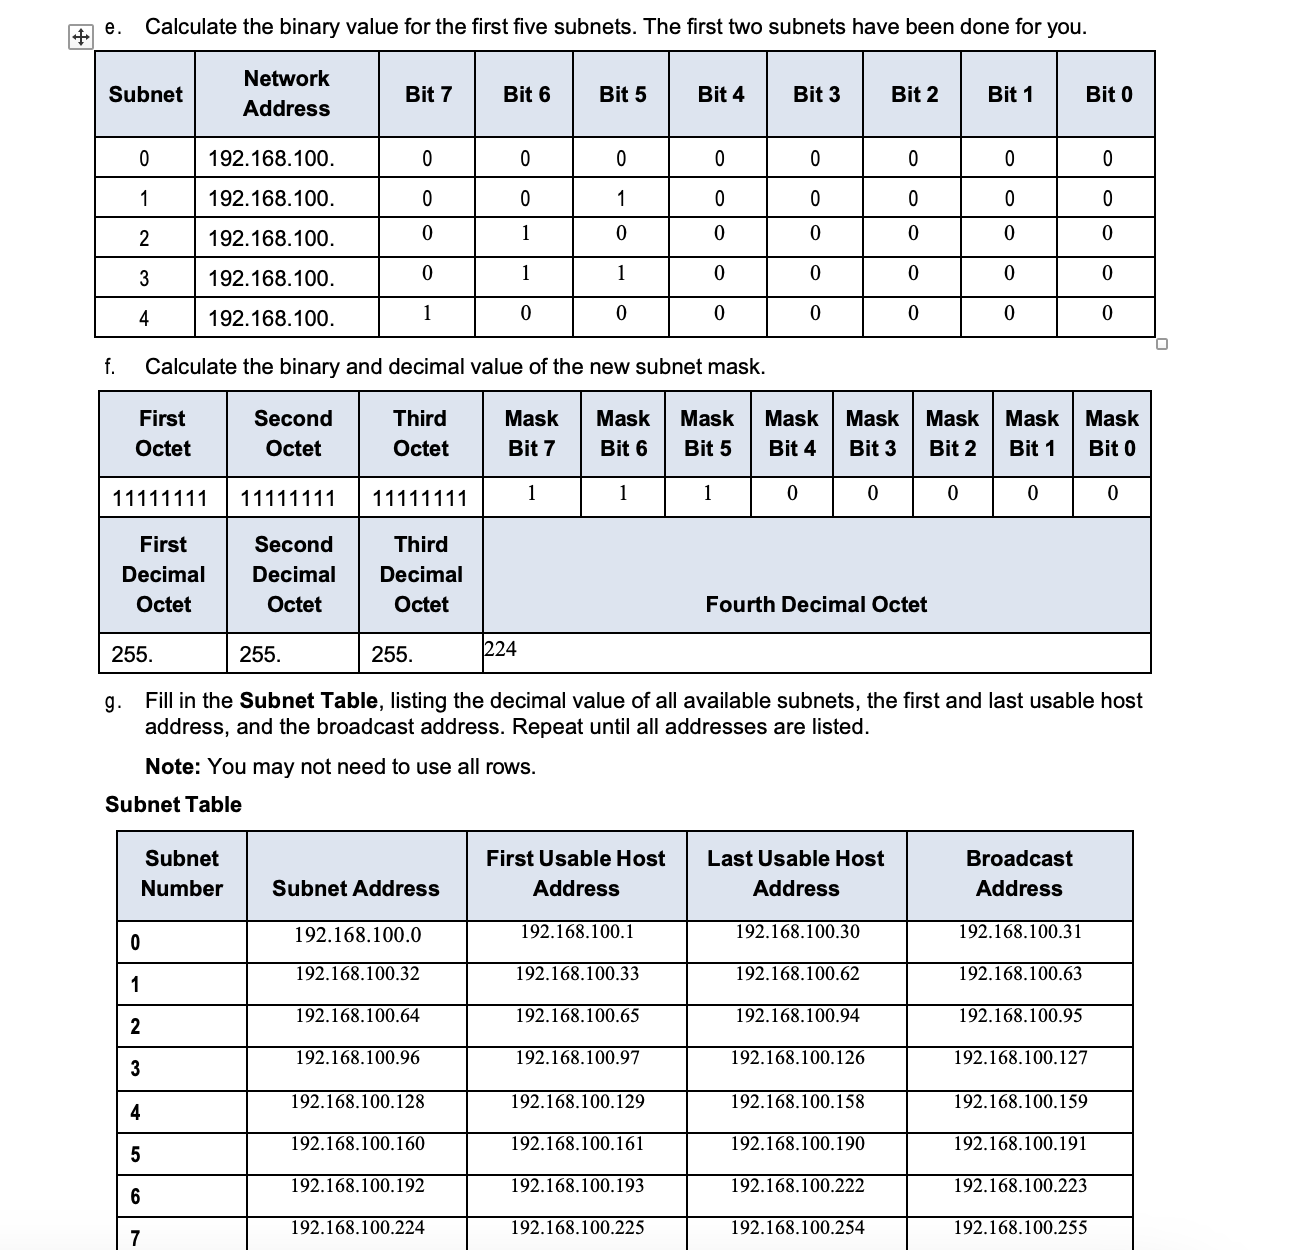

----

### 实操

上面说**router的一个port就应该分配一个ip(一个port是一个VLAN)**. 

比如router有Gig0/0, Gig0/1两个接口, 然后分别连接两个switch. 然后这两个接口的ip分别为`192.168.100.65/27`, `192.168.100.97/27` 那么理论上现在就是两个VLAN (并不是因为它连接了两个switch有了两个vlan, 而是它的这个两个接口的ip地址在不同网段). 

#### 怎么知道的这两个ip在不同网段?
```
/27表明subnet mask是27位, 所以比较两个ip的前27位是否相同来判断是否在一个网段:
第一个ip地址的第四部分65, 二进制为 1000 0001
第二个ip地址的第四部分97, 二进制为 1100 0001
前三位分别为100, 110 所以不在同一个网段
```

现在我们知道router的两个接口的ip地址属于不同的子网,其实**这两个接口的ip地址就是他们各自子网下终端设备的default gateway**. 也就是说PC3和switch6的默认网关, 就是接口g0/0,也就是`192.168.100.65/27`. PC4和switch8的默认网关就是`192.168.100.97`. 

#### 网关的作用是什么呢?
同一个vlan内的终端设备不需要默认网关, 甚至不需要ip地址, 他们在一个broadcast domain, 只需要mac地址便可以相互通信. 如果你想要问为什么只需要mac地址便可以通信, 那就请看下一节, 关于ARP协议的介绍(注意ARP与ARQ的区别). 

网关的作用就是帮助不同vlan间的设备相互通信, 没有网关, 你只能在一个局域网内通信, 不可能和另一个局域网通信. 

以交换机为中心的星形以太网是点对点传输的, 只要他们通过arp建立了mac表。以集线器(hub)为中心的星形以太网是以广播形式传播的，也就是每个主机都能收到其他所有主机的通讯，只不过不该他接受的他不理会而已。cmsa/cd是为了解决冲突而设计的载波侦听，在交换机的全双工状态下，依然是点对点工作。
除非你在交换机上又接了个hub，才会变成半双工，才会cmsa/cd解决冲突. 如果不知道cmsa/ca, 这篇文章介绍了具体的: https://zhuanlan.zhihu.com/p/603720907

---

看下面这个图, 

- 然后给路由器的g0/0, g0/1配置好ip地址

- 给两个pc配置上ip地址,子网掩码和默认网关(PC4的网关是g0/0的IP地址, PC3的网关不用我说了吧)

然后这两台电脑就能通信了


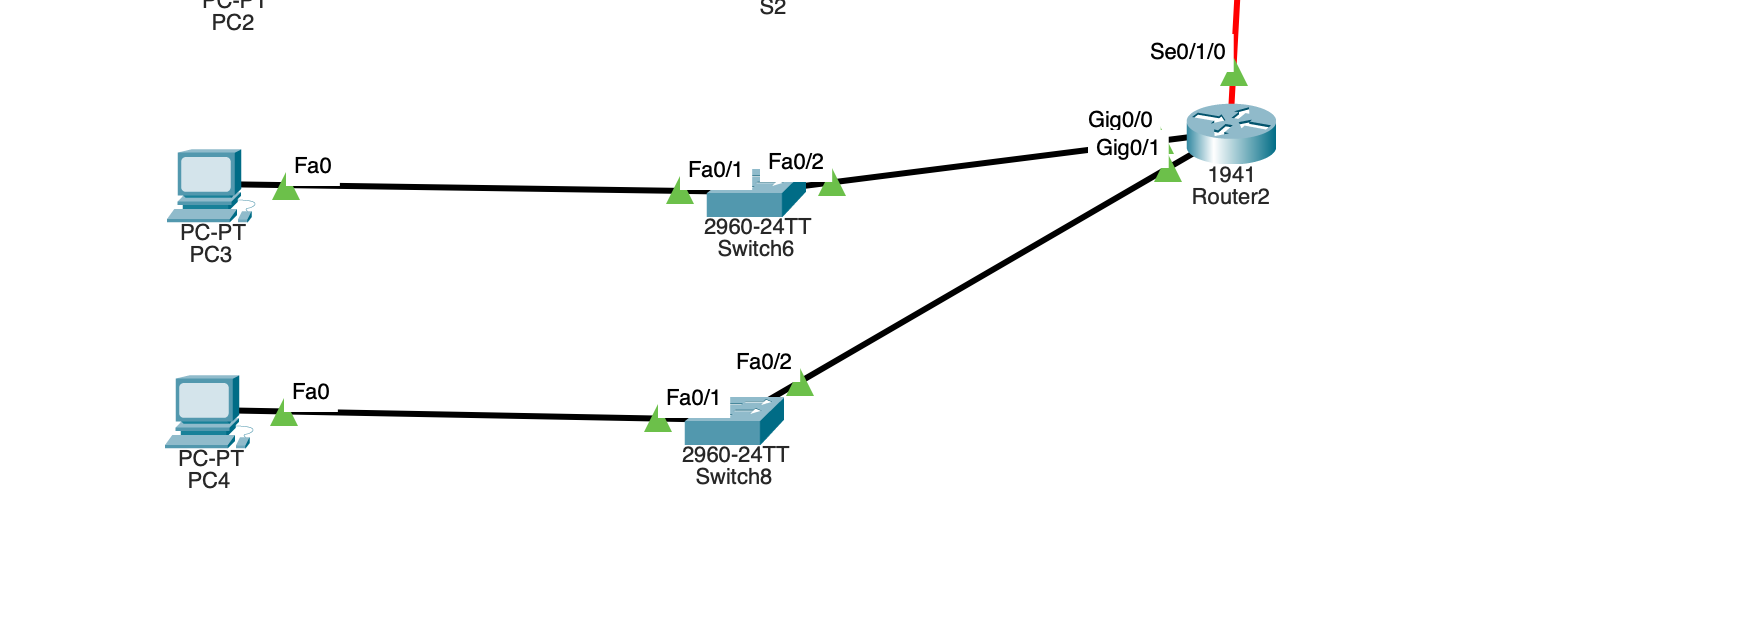